In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"d:\Data\SagittalSpineSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 30
batch_size = 24
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
WCE_weights = np.array([0.05, 0.95])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.9

# Evaluation parameters

acceptable_margin_mm = 0
mm_per_pixel = 1

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001,
                  0.0008, 0.0006, 0.0004, 0.0002, 0.0001]

# roc_thresholds = [0.8, 0.6, 0.4,  0.2, 0.1, 0.01]

Save timestamp: 2019-10-28_12-52-02


In [2]:
import os

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

Using TensorFlow backend.


In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

testing_ultrasound_filename = "ultrasound-test.npy"
testing_ultrasound_id = "5daa85edd9e6a3be02d012e7"
testing_segmentation_filename = "segmentation-test.npy"
testing_segmentation_id = "5daa85e7d9e6a3be02d012e4"

In [4]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"
test_data_folder      = "PredictionsTest"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)
test_data_fullpath = os.path.join(local_data_folder, test_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

if not os.path.exists(test_data_fullpath):
    os.makedirs(test_data_fullpath)
    print("Created folder: {}".format(test_data_fullpath))


In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

n_files = len(training_ultrasound_ids)

f = IntProgress(min=0, max=n_files*2)
display(f)

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
if not os.path.exists(test_ultrasound_fullname):
    print("Downloading {}...".format(test_ultrasound_fullname))
    gclient.downloadFile(testing_ultrasound_id, test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
if not os.path.exists(test_segmentation_fullname) or overwrite_existing_data_files:
    print("Downloading {}...".format(test_segmentation_fullname))
    gclient.downloadFile(testing_segmentation_id, test_segmentation_fullname)
    
time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.015931


In [6]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
test_ultrasound_array = np.load(test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
test_segmentation_array = np.load(test_segmentation_fullname)
    
time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.132647


Training started at: 2019-10-28 12:52:05.293589
Number of epochs:    30
Step size maximum:   0.02
Step size decay:     0.0006663333333333333
Batch size:          24
Regularization rate: 0.0001

*************************************  # 0

Training on 2767 images, validating on 523 images.



e:\dlenv\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Metrics at the end of training
  val_acc:   0.9906035059952599
  val loss:  0.0036466722973189664
  val_dice:  0.5139875030198471
  Total training time: 0:04:07.946166

Validation predictions saved to: d:\Data\SagittalSpineSegmentationStudy\PredictionsValidation\q000_ultrasound_prediction.npy
Testing predictions saved to:    d:\Data\SagittalSpineSegmentationStudy\PredictionsTest\prediction-test.npy
Model saved to: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model-0_2019-10-28_12-52-02.h5

Total round time:     0:05:43.634419


*************************************  # 1

Training on 2935 images, validating on 355 images.

Metrics at the end of training
  val_acc:   0.976699703344157
  val loss:  0.002599051839370333
  val_dice:  0.5277574557653615
  Total training time: 0:04:21.953722

Validation predictions saved to: d:\Data\SagittalSpineSegmentationStudy\PredictionsValidation\q001_ultrasound_prediction.npy
Testing predictions saved to:    d:\Data\

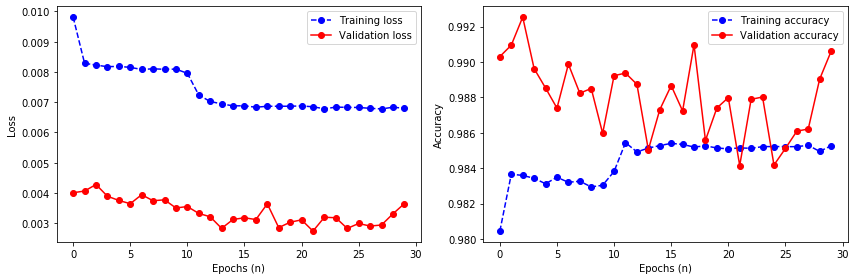

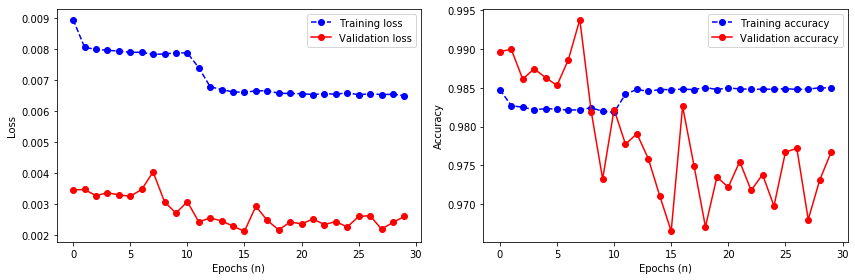

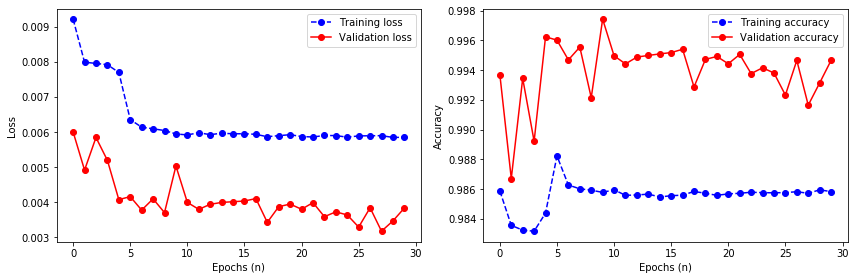

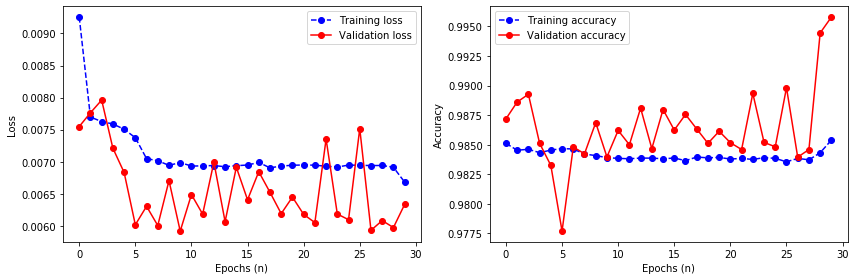

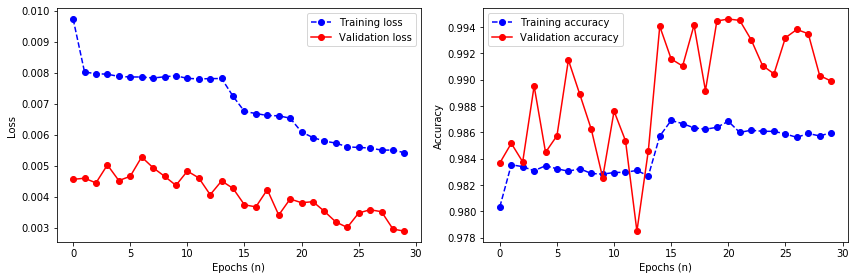

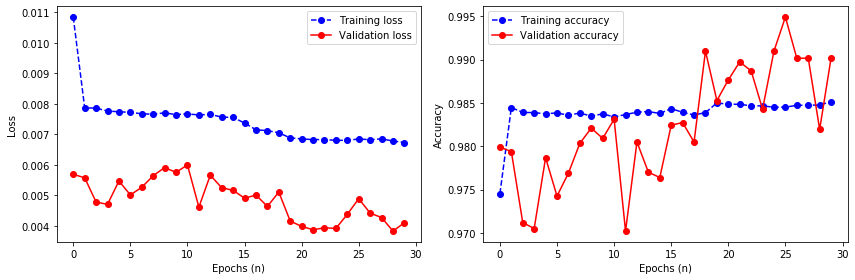

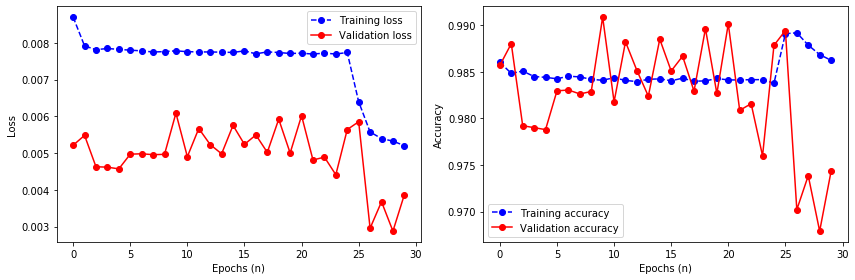

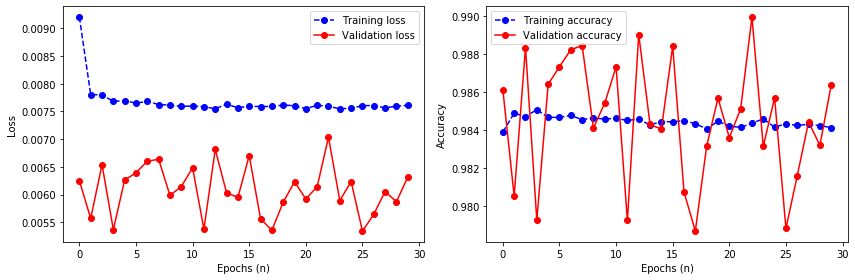

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()
print("Training started at: {}".format(time_sequence_start))
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))

val_aurocs          = np.zeros(n_files)
val_best_thresholds = np.zeros(n_files)
val_best_tp         = np.zeros(n_files)
val_best_fp         = np.zeros(n_files)
val_recall          = np.zeros(n_files)
val_precision       = np.zeros(n_files)
val_fscore          = np.zeros(n_files)
val_best_metrics    = dict()

test_aurocs          = np.zeros(n_files)
test_best_thresholds = np.zeros(n_files)
test_best_tp         = np.zeros(n_files)
test_best_fp         = np.zeros(n_files)
test_recall          = np.zeros(n_files)
test_precision       = np.zeros(n_files)
test_fscore          = np.zeros(n_files)
test_best_metrics    = dict()


for i in range(n_files):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = ultrasound_arrays[i]
    val_segmentation_data = segmentation_arrays[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(n_files):
        if train_index != i:
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("")
    print("*************************************  # {}".format(i))
    print("")
    print("Training on {} images, validating on {} images.".format(n_train, n_val))
    print("")
    
    # Create and train model
    
    model = unet.sagittal_spine_unet(ultrasound_size, num_classes, regularization_rate)
    
    model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
              loss=[unet.weighted_categorical_crossentropy(WCE_weights)],
              metrics=["accuracy", unet.dice_coef])
    
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
    
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(training_generator,
                                       validation_data=(val_ultrasound_data, val_segmentation_data),
                                       epochs=num_epochs,
                                       verbose=0)
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("Metrics at the end of training")
    print("  val_acc:  ", training_log.history['val_acc'][-1])
    print("  val loss: ", training_log.history['val_loss'][-1])
    print("  val_dice: ", training_log.history['val_dice_coef'][-1])
    print("  Total training time: {}\n".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['acc'], 'bo--')
    axes[1].plot(training_log.history['val_acc'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation and test data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    y_pred_test = model.predict(test_ultrasound_array)
    
    # Saving L-1-O prediction for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = filename_noext + "_prediction.npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    print("Validation predictions saved to: {}".format(val_prediction_fullname))

    # Saving test prediction for further evaluation
    
    test_prediction_filename = "prediction-test.npy"
    test_prediction_fullname = os.path.join(test_data_fullpath, test_prediction_filename)
    np.save(test_prediction_fullname, y_pred_test)
    print("Testing predictions saved to:    {}".format(test_prediction_fullname))
    
    # Archive trained model with unique filename based on timestamps
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    print("Model saved to: {}".format(model_fullname))
    
    # Validation output
    
    true_positives, false_positives, best_threshold_index, area, metrics_dicts = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_metrics = evaluation_metrics.compute_evaluation_metrics(
        y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_aurocs[i] = area
    val_best_thresholds[i] = roc_thresholds[best_threshold_index]
    val_best_tp[i] = true_positives[best_threshold_index]
    val_best_fp[i] = false_positives[best_threshold_index]
    val_best_metrics[i] = metrics_dicts[int(best_threshold_index)]
    
    val_recall[i] = val_metrics[evaluation_metrics.RECALL]
    val_precision[i] = val_metrics[evaluation_metrics.PRECISION]
    val_fscore[i] = val_metrics[evaluation_metrics.FSCORE]
    
    
    # Test the model
    
    true_positives, false_positives, best_threshold_index, area, metrics_dicts = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_test, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_aurocs[i] = area
    test_best_thresholds[i] = roc_thresholds[best_threshold_index]
    test_best_tp[i] = true_positives[best_threshold_index]
    test_best_fp[i] = false_positives[best_threshold_index]
    test_best_metrics[i] = metrics_dicts[best_threshold_index]
    
    test_metrics = evaluation_metrics.compute_evaluation_metrics(
        y_pred_test, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_recall[i] = test_metrics[evaluation_metrics.RECALL]
    test_precision[i] = test_metrics[evaluation_metrics.PRECISION]
    test_fscore[i] = test_metrics[evaluation_metrics.FSCORE]
    
    print("")
    print("Total round time:     {}".format(datetime.datetime.now() - training_time_start))
    print("")
    


time_sequence_stop = datetime.datetime.now()

print("\nAll training stopped at: {}".format(time_sequence_stop))
print("\nTotal training time:        {}".format(time_sequence_stop - time_sequence_start))


In [85]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

for i in range(n_files):
    results_df.loc[i] = [
        val_aurocs[i],
        val_best_thresholds[i],
        val_best_tp[i],
        val_best_fp[i],
        val_best_metrics[i][evaluation_metrics.RECALL],
        val_best_metrics[i][evaluation_metrics.PRECISION],
        val_recall[i],
        val_precision[i],
        val_fscore[i],
        test_aurocs[i],
        test_best_thresholds[i],
        test_best_tp[i],
        test_best_fp[i],
        test_best_metrics[i][evaluation_metrics.RECALL],
        test_best_metrics[i][evaluation_metrics.PRECISION],
        test_recall[i],
        test_precision[i],
        test_fscore[i]
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()

vali_means_df = pd.DataFrame(results_means_df.loc[:"Vali fuzzy Fscore"])
test_means_df = pd.DataFrame(results_means_df.loc["Test AUROC":])

# display(vali_means_df)

# print(vali_means_df[0]["Vali AUROC"])

means_df = pd.DataFrame(columns=["Validation", "Testing"])
for metric_name in metric_labels:
    means_df.loc[metric_name] = [vali_means_df[0]["Vali " + metric_name], 
                                 test_means_df[0]["Test " + metric_name]]

display(means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore,Test AUROC,Test best thresh,Test best TP,Test best FP,Test best recall,Test best precis,Test fuzzy recall,Test fuzzy precis,Test fuzzy Fscore
0,0.964081,0.06,0.919943,0.076763,0.919943,0.271799,0.393538,0.364395,0.378406,0.966079,0.35,0.958379,0.096284,0.958379,0.090561,0.775693,0.075601,0.137774
1,0.945260,0.10,0.925074,0.143146,0.925074,0.059987,0.445309,0.073797,0.126611,0.962350,0.45,0.960665,0.098695,0.960665,0.088737,0.841870,0.067328,0.124684
2,0.987222,0.04,0.969135,0.057820,0.969135,0.188543,0.357148,0.364836,0.360951,0.976757,0.55,0.967932,0.069981,0.967932,0.121553,0.907175,0.077484,0.142773
3,0.952654,0.04,0.964289,0.142385,0.964289,0.182957,0.267269,0.265599,0.266432,0.974488,0.45,0.957294,0.084093,0.957294,0.102243,0.830794,0.072089,0.132666
4,0.977597,0.04,0.975369,0.095481,0.975369,0.154848,0.436490,0.296158,0.352884,0.969371,0.30,0.940239,0.089572,0.940239,0.095035,0.809323,0.089040,0.160429
5,0.977905,0.08,0.953512,0.072250,0.953512,0.343095,0.383454,0.403732,0.393332,0.976339,0.50,0.955684,0.077714,0.955684,0.109549,0.853906,0.072706,0.134002
6,0.959732,0.06,0.934789,0.118312,0.934789,0.300684,0.579706,0.443604,0.502604,0.949848,0.10,0.938396,0.154204,0.938396,0.057387,0.541827,0.089086,0.153014
7,0.957029,0.04,0.984911,0.107098,0.984911,0.368543,0.257923,0.378523,0.306797,0.934658,0.30,0.966229,0.146537,0.966229,0.061884,0.723699,0.054216,0.100874



Averages


,Validation,Testing
AUROC,0.965185,0.963737
best thresh,0.057500,0.375000
best TP,0.953378,0.955602
best FP,0.101657,0.102135
best recall,0.953378,0.955602
best precis,0.233807,0.090868
fuzzy recall,0.390105,0.785536
fuzzy precis,0.323830,0.074694
fuzzy Fscore,0.336002,0.135777


In [9]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: d:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationStudy_2019-10-28_12-52-02.csv


In [10]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [11]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy_2019-10-28_12-52-02.html
